In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/multitarget-bioactivity-chembl/molecule_classification_dataset.csv")
df.head()


,Unnamed: 0,ChEMBL ID,Name,SMILES,Molecular Weight,LogP,HBA,HBD,TPSA,Protein
0,0,CHEMBL292323,NaN,COc1cccc2c(C(=O)Nc3ccccc3)c(SSc3c(C(=O)Nc4cccc...,622.77,7.99,8.0,2.0,86.52,EGFR
1,1,CHEMBL304414,NaN,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3ccccc3n2C)c(C(=O)N...,562.72,7.97,6.0,2.0,68.06,EGFR
2,2,CHEMBL62176,NaN,CN1C(=S)C(C(=O)Nc2ccccc2)c2ccccc21,282.37,3.19,2.0,1.0,32.34,EGFR
3,3,CHEMBL62701,NaN,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3cccnc3n2C)c(C(=O)N...,564.70,6.76,8.0,2.0,93.84,EGFR
4,4,CHEMBL137617,NaN,C/N=N/Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,357.22,4.54,5.0,2.0,74.56,EGFR


In [2]:
# Overview of the data types and non-null counts
print("\nDataset Info:")
print(df.info())

# Summary statistics of numerical columns
print("\nNumerical Description:")
print(df.describe())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8711 entries, 0 to 8710
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        8711 non-null   int64  
 1   ChEMBL ID         8711 non-null   object 
 2   Name              263 non-null    object 
 3   SMILES            8711 non-null   object 
 4   Molecular Weight  8711 non-null   float64
 5   LogP              8655 non-null   float64
 6   HBA               8655 non-null   float64
 7   HBD               8655 non-null   float64
 8   TPSA              8655 non-null   float64
 9   Protein           8711 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 680.7+ KB
None

Numerical Description:
        Unnamed: 0  Molecular Weight         LogP          HBA          HBD  \
count  8711.000000       8711.000000  8655.000000  8655.000000  8655.000000   
mean   4355.000000        461.894996     3.576049     5.686308 

In [3]:
# Drop unnamed index and Name column if they are not useful
df = df.drop(columns=["Unnamed: 0", "Name"])


In [4]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
ChEMBL ID            0
SMILES               0
Molecular Weight     0
LogP                56
HBA                 56
HBD                 56
TPSA                56
Protein              0
dtype: int64


In [5]:
df["LogP"] = df["LogP"].fillna(df["LogP"].mean())
df["HBA"] = df["HBA"].fillna(df["HBA"].median())
df["HBD"] = df["HBD"].fillna(df["HBD"].median())
df["TPSA"] = df["TPSA"].fillna(df["TPSA"].mean())


In [6]:
!pip install rdkit

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np


In [8]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

generator = GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.nan
    fp = generator.GetFingerprint(mol).ToBitString()
    return np.array([int(bit) for bit in fp])


In [9]:
# Convert SMILES to fingerprints
fingerprint_array = df["SMILES"].apply(smiles_to_fingerprint)

# Drop rows with invalid SMILES (where fingerprint is NaN)
valid_indices = fingerprint_array.dropna().index
df = df.loc[valid_indices].reset_index(drop=True)
fingerprint_array = fingerprint_array.dropna().reset_index(drop=True)


In [10]:
# Convert fingerprint series (list of arrays) to 2D NumPy array
X = np.stack(fingerprint_array.values)

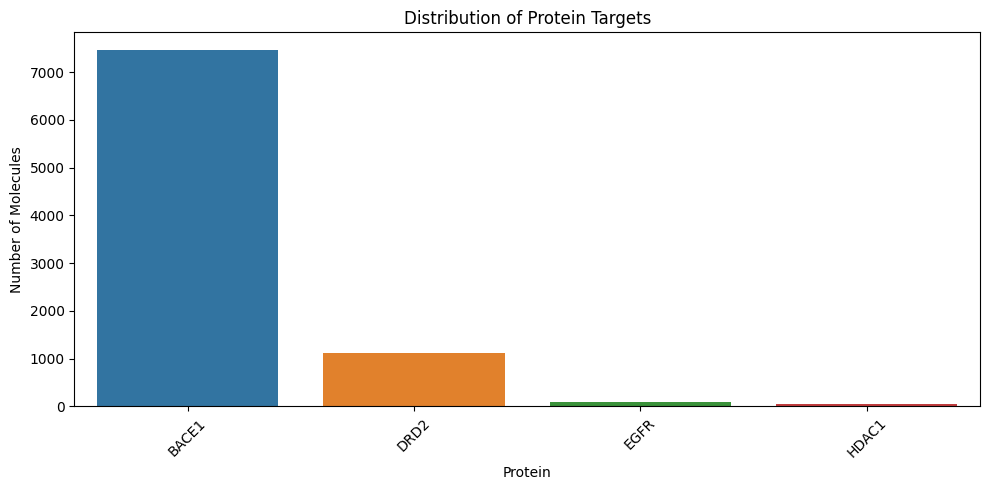

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Protein", order=df["Protein"].value_counts().index)
plt.title("Distribution of Protein Targets")
plt.xlabel("Protein")
plt.ylabel("Number of Molecules")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


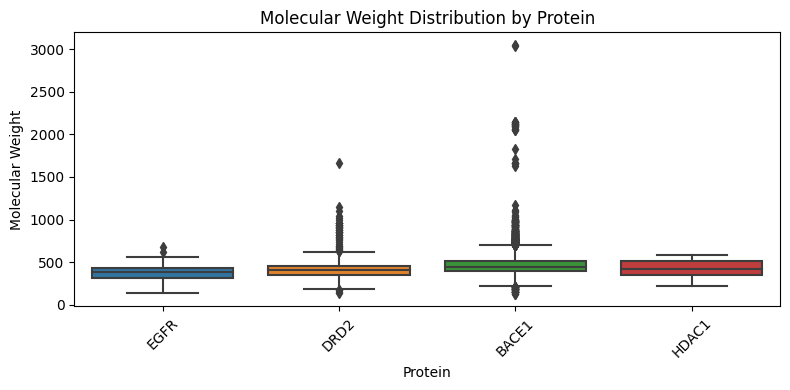

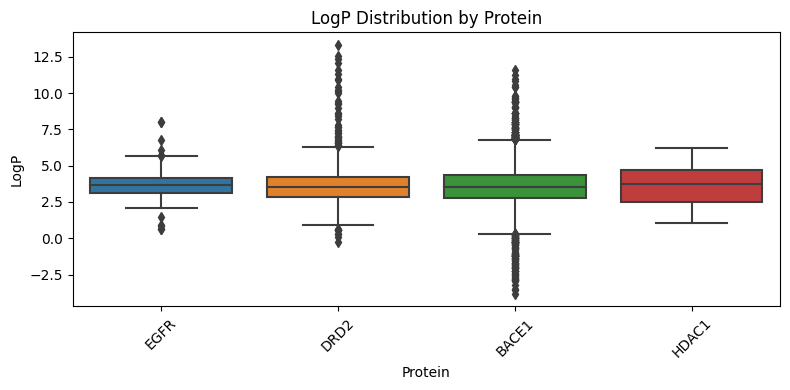

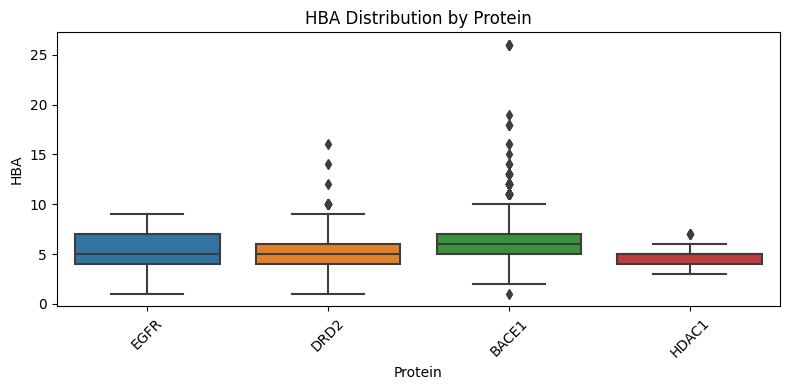

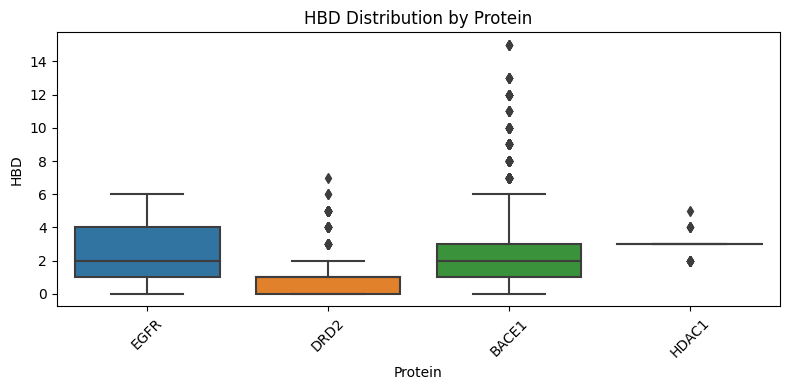

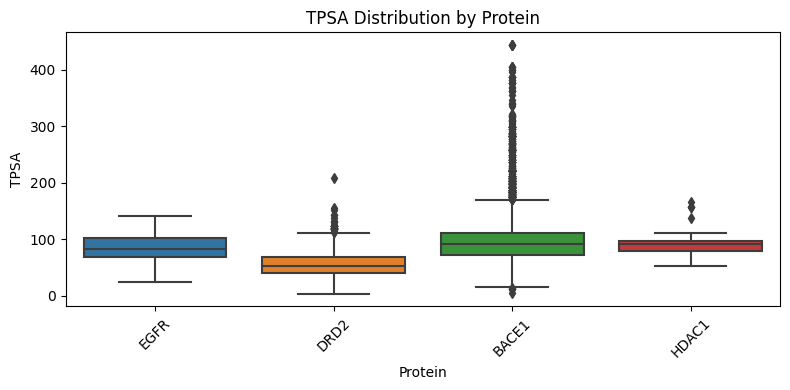

In [12]:
descriptor_cols = ["Molecular Weight", "LogP", "HBA", "HBD", "TPSA"]

for col in descriptor_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x="Protein", y=col)
    plt.title(f"{col} Distribution by Protein")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


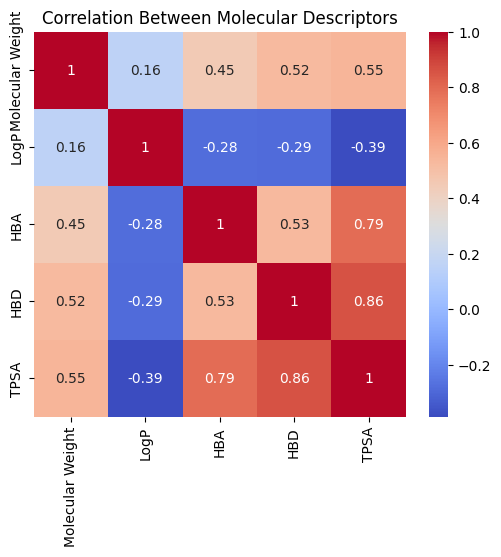

In [13]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[descriptor_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Molecular Descriptors")
plt.show()


In [ ]:
sns.pairplot(df[descriptor_cols + ["Protein"]], hue="Protein", corner=True, height=2.5)
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce to 2D for plotting
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)  # X = fingerprint array

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE-1", "TSNE-2"])
df_tsne["Protein"] = df["Protein"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x="TSNE-1", y="TSNE-2", hue="Protein", palette="tab10")
plt.title("t-SNE of Molecular Fingerprints")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# List of numerical descriptor columns
descriptor_cols = ["Molecular Weight", "LogP", "HBA", "HBD", "TPSA"]

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply outlier removal
df = remove_outliers_iqr(df, descriptor_cols)

# Reset index after filtering
df = df.reset_index(drop=True)

# Show shape after cleaning
print("Dataset shape after outlier removal:", df.shape)


In [ ]:
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

generator = GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.nan
    fp = generator.GetFingerprint(mol).ToBitString()
    return np.array([int(bit) for bit in fp])

# Apply to cleaned df
fingerprint_array = df["SMILES"].apply(smiles_to_fingerprint)

# Drop rows with invalid SMILES (if any)
valid_indices = fingerprint_array.dropna().index
df = df.loc[valid_indices].reset_index(drop=True)
fingerprint_array = fingerprint_array.dropna().reset_index(drop=True)

# Convert to final matrix
import numpy as np
X = np.stack(fingerprint_array.values)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Label encode
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Protein"])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:
# Number of classes
num_classes = len(np.unique(y_train))

# One-hot encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [ ]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(2048,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:

# Per-class accuracy
correct = (y_test == y_pred)
results_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred, "Correct": correct})
results_df["Actual_Label"] = label_encoder.inverse_transform(results_df["Actual"])
accuracy_per_class = results_df.groupby("Actual_Label")["Correct"].mean()

print("Per-Class Accuracy:")
print(accuracy_per_class)


In [ ]:
model.save("protein_classifier_model.h5")
